In [1]:
import casclik as cc
import casadi as cs
from matplotlib import pyplot as plt
%matplotlib inline

# WARNING!
# Animations take quite some time to create, and the code may stop for a couple of minutes at the animations
SHOW_ANIMATIONS = False
from matplotlib import animation
from IPython.display import HTML

# Simple 2D example: The double pendulum

Here we will revisit that good ol' control problem: the double pendulum. In our minds it is the archetype of a robot arm, made with two links and two actuated revolute joints.

We have $\mathbf{q}=[q_1,q_2]^T\in\mathbb{R}^2$ as the joint angles, each link has a uniformly distributed mass: $M_1,M_2$, each link has a length: $l_1,l_2$ giving the Cartesian position of the end-effector such that:
$$
p_x = l_1\cos(q_1) + l_2\cos(q_1+q_2)\\
p_y = l_1\sin(q_1) + l_2\sin(q_1+q_2)
$$
We assume that the motors on the joints are perfectly tuned (or just much faster than the update rate of the closed-loop inverse kinematics controller) such that the desired joint speed is the applied joint speed giving:
$$
q_1(t) = \int_{\tau=0}^{\tau=t}\dot{q}_1(\tau)\mathrm{d}\tau\\
q_2(t) = \int_{\tau=0}^{\tau=t}\dot{q}_2(\tau)\mathrm{d}\tau
$$
and the control inputs are piecewise constant, with $t(k\Delta_t) = t_k$ and $\dot{q}(t_k)=\dot{q}_k$, giving:
$$
q_{1,k} = \sum_{i=0}^{i=k}\dot{q}_{1,i}\Delta_t\\
q_{2,k} = \sum_{i=0}^{i=k}\dot{q}_{1,i}\Delta_t
$$

In this example we'll be playing around with some more advanced cost functions, so let's define the dynamics as well:
$$
\mathbf{M}(\mathbf{q})\ddot{\mathbf{q}} + \mathbf{C}(\mathbf{q},\dot{\mathbf{q}})\dot{\mathbf{q}} + \mathbf{G}(\mathbf{q}) = \mathbf{\tau}
$$
where $\mathbf{\tau} = [\tau_1,\tau_2]^T$ are the torques, $\mathbf{M}(\mathbf{q})$ is the inertia matrix, $\mathbf{C}(\mathbf{q},\dot{\mathbf{q}})$ is the coriolis matrix, and $\mathbf{G}(\mathbf{q})$ is the gravity.

Where:
$$
\mathbf{M}(\mathbf{q}) = \begin{bmatrix}
\alpha + 2\beta\cos(q_2) & \delta + \beta\cos(q_2)\\
\delta + \beta\cos(q_2) & \delta
\end{bmatrix}\\
\mathbf{C}(\mathbf{q},\dot{\mathbf{q}})=\begin{bmatrix}
-\beta \sin(q_2) & -\beta \sin(q_2)(\dot{q}_1 + \dot{q}_2)\\
\beta\sin(q_2) & 0
\end{bmatrix}\\
\mathbf{G}(\mathbf{q}) = \begin{bmatrix}
g_1\cos(q_1) + g_2\cos(q_1+q_2)\\
g_2\cos(q_1+q_2)
\end{bmatrix}
$$
with the parameters:
$$
\alpha = \frac{1}{3}m_1l_1^2 + \frac{1}{3}m_2l_2^2 + m_2l_1^2\\
\beta = \frac{1}{2}m_2l_2l_1\\
\delta = \frac{1}{3}m_2l_2^2\\
g_1 = g l_1 \left(\frac{m_1}{2} + m_2\right)\\
g_2 = \frac{1}{2}g l_2 m_2
$$

So let's start defining our symbols and some numerics:

In [2]:
# Numerics
l_1 = 1.0 # m
l_2 = 0.75 # m
m_1 = 0.5 # kg
m_2 = 0.3 # kg
g = 9.81 # m s^{-2}, standard earth
alpha = (m_1*l_1**2)/3.0 + (m_2*l_2**2)/3.0 + m_2*l_1**2
beta = (m_2*l_2*l_1)/2.0
delta = (m_2*l_2**2)/3.0
g_1 = g*l_1*(m_1/2.0 + m_2)
g_2 = g*l_2*m_2/2.0

# Symbols
t = cs.MX.sym("t")
q = cs.MX.sym("q",2)
dq = cs.MX.sym("dq",2)

In [3]:
# Then forward kinematics as a symbol:
p_mid = cs.vertcat(l_1*cs.cos(q[0]),
                   l_1*cs.sin(q[0]))

p = cs.vertcat(l_1*cs.cos(q[0]) + l_2*cs.cos(q[0]+q[1]), 
               l_1*cs.sin(q[0]) + l_2*cs.sin(q[0]+q[1]))
# Then forward kinematics as a function:
fp_mid = cs.Function("fp_mid", [q], [p_mid],
                    ["q"], ["p_mid"])
fp = cs.Function("fp",[q],[p],
                ["q"],["p"]) # It's generally good to name the inputs and outputs. This makes it easier to read debugs.

In [4]:
# Then dynamic parameters:
M_11 = alpha + 2*beta*cs.cos(q[1])
M_12 = delta + beta*cs.cos(q[1])
M_22 = delta
M = cs.vertcat(cs.horzcat(M_11, M_12),
               cs.horzcat(M_12, M_22))
C_11 = -beta*cs.sin(q[1])
C_12 = -beta*cs.sin(q[1])*(dq[0]+dq[1])
C_21 = beta*cs.sin(q[1])
C = cs.vertcat(cs.horzcat(C_11, C_12),
               cs.horzcat(C_21, 0.0))

G_1 = g_1*cs.cos(q[0]) + g_2*cs.cos(q[0]+q[1])
G_2 = g_2*cs.cos(q[0]+q[1])
G = cs.vertcat(G_1,
               G_2)
# Then dynamic parameters as functions:
fM = cs.Function("fM", [q], [M],
                ["q"], ["M"])
fC = cs.Function("fC", [q,dq], [C],
                ["q","dq"], ["C"])
fG = cs.Function("fG", [q], [G],
                ["q"], ["G"])

## Defining a skill: Moving to a point
We want to move to some $p_{des}$ (`p_des`). Let's say the robot is on a table and is not allowed to put the end-effector or the "midpoint" (first joint) through the table. Our motors can only move at 0.1 rad/s.

In [5]:
# Numerics for the skill:
p_des = cs.vertcat(0.75, # m
                   0.5)# m
max_speed = 0.5 # rad/s
table_height = -0.05 # m below the origin of the robot.

In [6]:
# Defining the constraint to get there:
dist_error = p_des - p
min_dist_cnstr = cc.EqualityConstraint(
    label = "min_dist_cnstr",
    expression = dist_error,
    gain = 1.0,
    constraint_type="soft") # The speed limit is hard, so this must be soft, or the problem will be infeasible.

In [7]:
# Defining the constraint to limit the joint speeds:
speed_limit_cnstr = cc.VelocitySetConstraint(
    label = "speed_limit_cnstr",
    expression = q,
    set_min = -cs.vertcat(max_speed, max_speed),
    set_max = cs.vertcat(max_speed, max_speed))

In [8]:
# Defining the constraints to not hit the table with the joints:
# "Midpoint":
dist_table_midpoint = p_mid[1] - table_height
table_midpoint_cnstr = cc.SetConstraint(
    label = "table_midpoint_cnstr",
    expression = dist_table_midpoint,
    set_min = 0.0,
    set_max = cs.inf)

# "Endpoint":
dist_table_endpoint = p[1] - table_height
table_endpoint_cnstr = cc.SetConstraint(
    label = "table_endpoint_cnstr",
    expression = dist_table_endpoint,
    set_min = 0.0,
    set_max = cs.inf)

In [9]:
# Define the skill:
point_skill = cc.SkillSpecification(
    label = "move_to_point_skill",
    time_var = t,
    robot_var = q,
    robot_vel_var = dq,
    constraints = [min_dist_cnstr,
                   speed_limit_cnstr,
                   table_midpoint_cnstr,
                   table_endpoint_cnstr])
point_skill.print_constraints()

SkillSpecification: move_to_point_skill
#0: min_dist_cnstr
#1: speed_limit_cnstr
#2: table_midpoint_cnstr
#3: table_endpoint_cnstr
N constraints: 4
N equality:
	Pos:1	Vel:0
N set:
	Pos:2	Vel:1


Now, let's try to execute this with a few different controllers!

### Reactive QP Approach

In [10]:
# Define the controller
qpcntrllr = cc.ReactiveQPController(
    skill_spec = point_skill,
    robot_var_weights = [1.0, 1.0])
qpcntrllr.setup_problem_functions()
qpcntrllr.setup_solver()

In [11]:
%%timeit # Let's check the timing with a random point in the range
test_initial = 0.5*cs.np.pi*cs.vertcat(cs.np.random.rand(), cs.np.random.rand()) + 0.25*cs.np.pi
qpcntrllr.solve(time_var=0.0, robot_var=test_initial)#cs.vertcat(0.1,0.1))

334 µs ± 9.98 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [12]:
# Simulate it!
dt = 0.01
t_sim = cs.np.array([dt*i for i in range(800)])
# Robot
q_sim = cs.np.zeros((len(t_sim),q.shape[0]))
q_sim[0,:] = [cs.np.pi/2 - 1e-5, 0.0]
dq_sim = cs.np.zeros((len(t_sim),dq.shape[0]))
# Cartesian
p_sim = cs.np.zeros((len(t_sim),p.shape[0]))
p_mid_sim = cs.np.zeros((len(t_sim),p_mid.shape[0]))
# Loop
for i in range(len(t_sim) - 1):
    dq_sim[i,:] = qpcntrllr.solve(t_sim[i], q_sim[i,:])[0].toarray()[:,0]
    q_sim[i+1,:] = q_sim[i,:] + dq_sim[i,:]*dt
    p_mid_sim[i+1,:] = fp_mid(q_sim[i+1,:]).toarray()[:,0]
    p_sim[i+1,:] = fp(q_sim[i+1,:]).toarray()[:,0]

In [13]:
# Let's package results for easier comparison of the controllers:
sim_point_qp = {"t_sim": t_sim,
                "dq_sim": dq_sim,
                 "q_sim": q_sim,
                 "p_mid_sim": p_mid_sim,
                 "p_sim":p_sim}

# And define some plot functions
def plot_joints(simres, axs=None):
    if axs is None:
        fig, axs = plt.subplots(2,1)
    axs[0].plot(simres["t_sim"], simres["q_sim"][:,0], label="q0")
    axs[0].plot(simres["t_sim"], simres["q_sim"][:,1], label="q1")
    axs[0].set_ylabel("position [rad]")
    axs[1].plot(simres["t_sim"], simres["dq_sim"][:,0], label="dq0")
    axs[1].plot(simres["t_sim"], simres["dq_sim"][:,1], label="dq1")
    axs[1].plot([min(simres["t_sim"]),max(simres["t_sim"])],[max_speed, max_speed],'k--')
    axs[1].plot([min(simres["t_sim"]),max(simres["t_sim"])],[-max_speed, -max_speed],'k--')
    axs[1].set_ylabel("speed [rad/s]")
    axs[1].set_xlabel("t [s]")
    axs[0].legend()
    axs[1].legend()

def plot_pos(simres, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.plot(simres["t_sim"], simres["p_sim"][:,0], label="p_x",color="b")
    ax.plot(simres["t_sim"], simres["p_sim"][:,1], label="p_y",color="g")
    ax.plot([min(simres["t_sim"]), max(simres["t_sim"])], [p_des[0], p_des[0]], label="p_des_x", color="b", ls="--")
    ax.plot([min(simres["t_sim"]), max(simres["t_sim"])], [p_des[1], p_des[1]], label="p_des_y", color="g", ls="--")
    ax.set_ylabel("position [m]")
    ax.set_xlabel("time [s]")
    ax.legend()

def animate_pos(simres):
    fig, ax = plt.subplots(1,1)
    ax.plot([-(l_1+l_2), l_1+l_2], [table_height, table_height], color="k",lw=3,label="table")
    line0, = ax.plot([],[],color="b",marker="o",lw=2,ls="-")
    line1, = ax.plot([],[],color="b",marker="o",lw=2,ls="-")
    ax.set_xlim([-1.1*(l_1+l_2), 1.1*(l_1+l_2)])
    ax.set_ylim([-1.1*(l_1+l_2), 1.1*(l_1+l_2)])
    def init():
        line0.set_data([],[])
        line1.set_data([],[])
        return line0,line1
    def animate(i):
        ax.set_title("Iteration: "+str(i)+" Time: "+str(dt*i))
        line0.set_data([0, simres["p_mid_sim"][i,0]], [0, simres["p_mid_sim"][i,1]])
        line1.set_data([simres["p_mid_sim"][i,0], simres["p_sim"][i,0]], [simres["p_mid_sim"][i,1], simres["p_sim"][i,1]])
        return line0, line1
    if SHOW_ANIMATIONS:
        anim_pos = animation.FuncAnimation(fig, animate, init_func=init,
                                       frames=len(t_sim)-1, interval=int(1000*dt), blit=True)
        return anim_pos.to_html5_video()
    else:
        return None

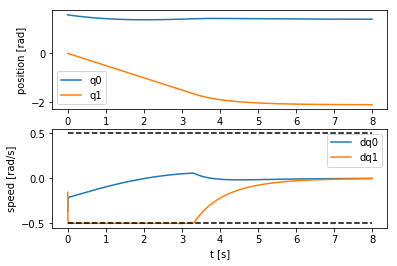

In [14]:
plot_joints(sim_point_qp)

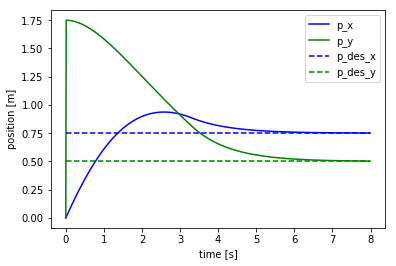

In [15]:
plot_pos(sim_point_qp)

<IPython.core.display.HTML object>

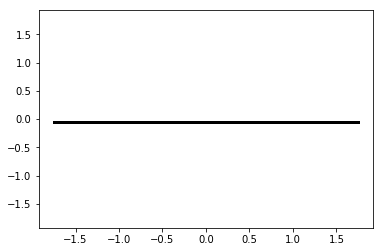

In [16]:
HTML(animate_pos(sim_point_qp))

### Reactive NLP Formulation
Here our cost expression can be chosen however we want. So how about testing two different scenarios. The first is an energy based cost, where the cost is based on the actual kinetic energy of the manipulator:
$$
f_{\text{cost}}(t) = \int_{0}^t \frac{1}{2}\dot{\mathbf{q}}^T\mathbf{M}(\mathbf{q})\dot{\mathbf{q}}
$$

In [17]:
# Define the controller
energynlpcntrllr = cc.ReactiveNLPController(
        skill_spec = point_skill,
    cost_expr=0.5*cs.mtimes(cs.mtimes(dq.T,fM(q)),dq))
energynlpcntrllr.setup_problem_functions()
energynlpcntrllr.setup_solver()

In [18]:
%%timeit # Let's check the timing with a random point in the range
test_initial = 0.5*cs.np.pi*cs.vertcat(cs.np.random.rand(), cs.np.random.rand()) + 0.25*cs.np.pi
energynlpcntrllr.solve(time_var=0.0, robot_var=test_initial)#cs.vertcat(0.1,0.1))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

6.06 ms ± 563 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
# Simulate it!
dt = 0.01
t_sim = cs.np.array([dt*i for i in range(800)])
# Robot
q_sim = cs.np.zeros((len(t_sim),q.shape[0]))
q_sim[0,:] = [cs.np.pi/2 - 1e-5, 0.0]
dq_sim = cs.np.zeros((len(t_sim),dq.shape[0]))
# Cartesian
p_sim = cs.np.zeros((len(t_sim),p.shape[0]))
p_mid_sim = cs.np.zeros((len(t_sim),p_mid.shape[0]))
# Loop
for i in range(len(t_sim) - 1):
    dq_sim[i,:] = energynlpcntrllr.solve(t_sim[i], q_sim[i,:])[0].toarray()[:,0]
    q_sim[i+1,:] = q_sim[i,:] + dq_sim[i,:]*dt
    p_mid_sim[i+1,:] = fp_mid(q_sim[i+1,:]).toarray()[:,0]
    p_sim[i+1,:] = fp(q_sim[i+1,:]).toarray()[:,0]

In [20]:
# Let's package results for easier comparison of the controllers:
sim_point_energynlp = {"t_sim": t_sim,
                       "dq_sim": dq_sim,
                       "q_sim": q_sim,
                       "p_mid_sim": p_mid_sim,
                       "p_sim":p_sim}

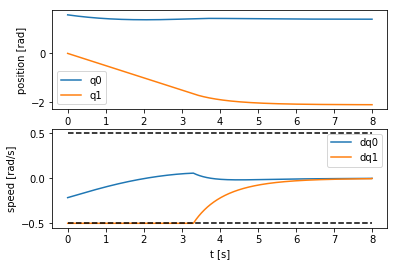

In [21]:
plot_joints(sim_point_energynlp)

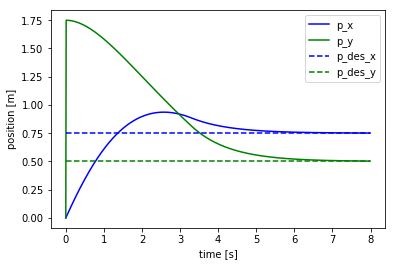

In [22]:
plot_pos(sim_point_energynlp)

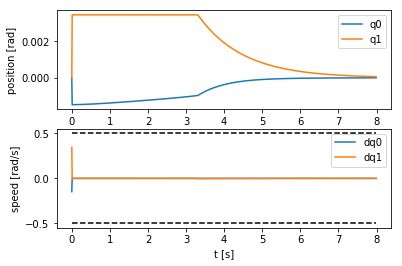

In [23]:
err_dict = {}
for k in sim_point_qp.keys():
    err_dict[k] = sim_point_qp[k] - sim_point_energynlp[k]
err_dict["t_sim"] = sim_point_qp["t_sim"]
plot_joints(err_dict)

<IPython.core.display.HTML object>

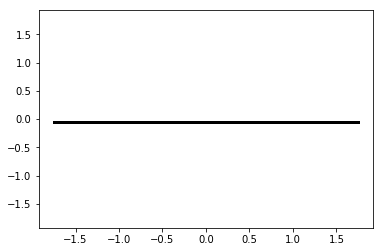

In [24]:
HTML(animate_pos(sim_point_energynlp))

## Defining a time-dependent skill: Moving to a trajectory
In this case the $p_{des}$ is a trajectory: $p_{des}(t)$. Let's say a little circe in the workspace.
$$
p_{des}(t) = r_{circ}\begin{bmatrix}
\cos(\omega_{circ} t)\\
\sin(\omega_{circ} t)
\end{bmatrix} + \begin{bmatrix}
o_{circ,x}\\
o_{circ,y}
\end{bmatrix}
$$

In [25]:
# Numerics of the trajectory
r_circ = 0.25
omega_circ = 0.5
o_circ_x = 1.0
o_circ_y = 1.0
# Trajectory symbol
p_des_traj = r_circ*cs.vertcat(cs.cos(omega_circ*t), cs.sin(omega_circ*t)) + cs.vertcat(o_circ_x, o_circ_y)
# Trajectory function
fp_des_traj = cs.Function("p_des_traj", [t], [p_des_traj])

In [26]:
# Define the tracking constraint
track_error = p_des_traj - p
min_track_cnstr = cc.EqualityConstraint(
    label = "min_track_cnstr",
    expression = track_error,
    gain = 1.0,
    constraint_type="soft") # The speed limit is hard, so this must be soft, or the problem will be infeasible.

In [27]:
# Define the skill:
track_skill = cc.SkillSpecification(
    label = "track_trajectory_skill",
    time_var = t,
    robot_var = q,
    robot_vel_var = dq,
    constraints = [min_track_cnstr,
                   speed_limit_cnstr,
                   table_midpoint_cnstr,
                   table_endpoint_cnstr])
track_skill.print_constraints()

SkillSpecification: track_trajectory_skill
#0: min_track_cnstr
#1: speed_limit_cnstr
#2: table_midpoint_cnstr
#3: table_endpoint_cnstr
N constraints: 4
N equality:
	Pos:1	Vel:0
N set:
	Pos:2	Vel:1


### Reactive QP approach

In [28]:
# Define the controller
qpcntrllr = cc.ReactiveQPController(
    skill_spec = track_skill,
    robot_var_weights = [1.0, 1.0])
qpcntrllr.setup_problem_functions()
qpcntrllr.setup_solver()

In [29]:
# Simulate it!
dt = 0.01
t_sim = cs.np.array([dt*i for i in range(2000)])
# Robot
q_sim = cs.np.zeros((len(t_sim),q.shape[0]))
q_sim[0,:] = [cs.np.pi/2 - 1e-5, 0.0]
dq_sim = cs.np.zeros((len(t_sim),dq.shape[0]))
# Cartesian
p_sim = cs.np.zeros((len(t_sim),p.shape[0]))
p_mid_sim = cs.np.zeros((len(t_sim),p_mid.shape[0]))
# Loop
for i in range(len(t_sim) - 1):
    dq_sim[i,:] = qpcntrllr.solve(t_sim[i], q_sim[i,:])[0].toarray()[:,0]
    q_sim[i+1,:] = q_sim[i,:] + dq_sim[i,:]*dt
    p_mid_sim[i+1,:] = fp_mid(q_sim[i+1,:]).toarray()[:,0]
    p_sim[i+1,:] = fp(q_sim[i+1,:]).toarray()[:,0]

In [30]:
# Let's package results for easier comparison of the controllers:
sim_track_qp = {"t_sim": t_sim,
                "dq_sim": dq_sim,
                 "q_sim": q_sim,
                 "p_mid_sim": p_mid_sim,
                 "p_sim":p_sim}

# Define a plot function for tracking
def plot_track(simres, ax=None, trajectory_func=None):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.plot(simres["t_sim"], simres["p_sim"][:,0], label="p_x",color="b")
    ax.plot(simres["t_sim"], simres["p_sim"][:,1], label="p_y",color="g")
    if trajectory_func is not None:
        ax.plot(simres["t_sim"], cs.np.array([trajectory_func(i).toarray()[:,0] for i in simres["t_sim"]]), "k--")
    ax.set_ylabel("position [m]")
    ax.set_xlabel("time [s]")
    ax.legend()
def animate_track(simres, trajectory_func=None):
    fig, ax = plt.subplots(1,1)
    ax.plot([-(l_1+l_2), l_1+l_2], [table_height, table_height], color="k",lw=3,label="table")
    line0, = ax.plot([],[],color="b",marker="o",lw=2,ls="-")
    line1, = ax.plot([],[],color="b",marker="o",lw=2,ls="-")
    if trajectory_func is not None:
        ax.plot([trajectory_func(i).toarray()[0,0] for i in simres["t_sim"]], 
                [trajectory_func(i).toarray()[1,0] for i in simres["t_sim"]], "k--")
    ax.set_xlim([-1.1*(l_1+l_2), 1.1*(l_1+l_2)])
    ax.set_ylim([-1.1*(l_1+l_2), 1.1*(l_1+l_2)])
    def init():
        line0.set_data([],[])
        line1.set_data([],[])
        return line0,line1
    def animate(i):
        ax.set_title("Iteration: "+str(i)+" Time: "+str(dt*i))
        line0.set_data([0, simres["p_mid_sim"][i,0]], [0, simres["p_mid_sim"][i,1]])
        line1.set_data([simres["p_mid_sim"][i,0], simres["p_sim"][i,0]], [simres["p_mid_sim"][i,1], simres["p_sim"][i,1]])
        return line0, line1
    if SHOW_ANIMATIONS:
        anim_pos = animation.FuncAnimation(fig, animate, init_func=init,
                                       frames=len(t_sim)-1, interval=int(1000*dt), blit=True)
        return anim_pos.to_html5_video()
    else:
        return None

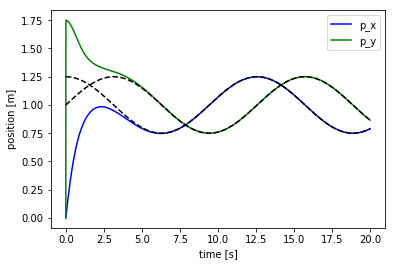

In [31]:
plot_track(sim_track_qp, trajectory_func=fp_des_traj)

<IPython.core.display.HTML object>

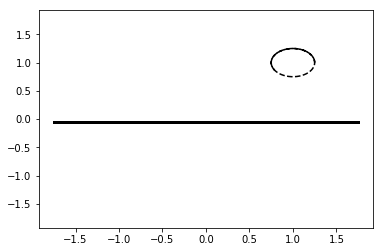

In [32]:
HTML(animate_track(sim_track_qp, trajectory_func=fp_des_traj))

### Model predictive approach

In [33]:
# Define the controller
mpcntrllr = cc.ModelPredictiveController(
    skill_spec = track_skill,
    cost_expr = dq[0]*dq[0] + dq[1]*dq[1])
mpcntrllr.setup_problem_functions()
mpcntrllr.setup_solver()

In [34]:
# Simulate it!
dt = 0.01
t_sim = cs.np.array([dt*i for i in range(2000)])
# Robot
q_sim = cs.np.zeros((len(t_sim),q.shape[0]))
q_sim[0,:] = [cs.np.pi/2 - 1e-5, 0.0001]
dq_sim = cs.np.zeros((len(t_sim),dq.shape[0]))
# Cartesian
p_sim = cs.np.zeros((len(t_sim),p.shape[0]))
p_mid_sim = cs.np.zeros((len(t_sim),p_mid.shape[0]))
# Loop
for i in range(len(t_sim) - 1):
    dq_sim[i,:] = mpcntrllr.solve(t_sim[i], q_sim[i,:])[0].toarray()[:,0]
    q_sim[i+1,:] = q_sim[i,:] + dq_sim[i,:]*dt
    p_mid_sim[i+1,:] = fp_mid(q_sim[i+1,:]).toarray()[:,0]
    p_sim[i+1,:] = fp(q_sim[i+1,:]).toarray()[:,0]

In [35]:
# Let's package results for easier comparison of the controllers:
sim_track_mpc = {"t_sim": t_sim,
                "dq_sim": dq_sim,
                 "q_sim": q_sim,
                 "p_mid_sim": p_mid_sim,
                 "p_sim":p_sim}

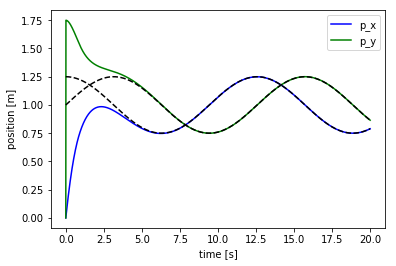

In [36]:
plot_track(sim_track_mpc, trajectory_func=fp_des_traj)

<IPython.core.display.HTML object>

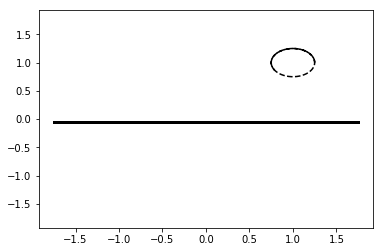

In [37]:
HTML(animate_track(sim_track_mpc, trajectory_func=fp_des_traj))